In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.22MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.05MB/s]


In [5]:
def add_noise(inputs, noise_factor=0.5):
    noisy = inputs + noise_factor * torch.randn_like(inputs)
    return torch.clamp(noisy, 0., 1.)

In [6]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
            nn.Conv2d(16, 8, kernel_size=3, padding=1),  # 14x14 -> 14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 14x14 -> 7x7
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),  # 14x14 -> 28x28
            nn.Sigmoid()  # Ensure output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4            [-1, 8, 14, 14]           1,160
              ReLU-5            [-1, 8, 14, 14]               0
         MaxPool2d-6              [-1, 8, 7, 7]               0
   ConvTranspose2d-7           [-1, 16, 14, 14]             528
              ReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]              65
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 1,913
Trainable params: 1,913
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 0.01
Estimated Total

In [9]:
def train(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in loader:
            images = images.to(device)
            noisy_images = add_noise(images).to(device)

            outputs = model(noisy_images)
            loss = criterion(outputs, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(loader):.4f}")

In [12]:
def visualize_denoising(model, loader, num_images=5):
    model.eval()
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            noisy_images = add_noise(images).to(device)
            outputs = model(noisy_images)
            break

    images = images.cpu().numpy()
    noisy_images = noisy_images.cpu().numpy()
    outputs = outputs.cpu().numpy()

    print("Name:  BHAVYASHREE R")
    print("Register Number: 212223110006")
    plt.figure(figsize=(18, 6))
    for i in range(num_images):
        # Original
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title("Original")
        plt.axis("off")

        # Noisy
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(noisy_images[i].squeeze(), cmap='gray')
        ax.set_title("Noisy")
        plt.axis("off")

        # Denoised
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(outputs[i].squeeze(), cmap='gray')
        ax.set_title("Denoised")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Epoch [1/5], Loss: 0.0204
Epoch [2/5], Loss: 0.0199
Epoch [3/5], Loss: 0.0195
Epoch [4/5], Loss: 0.0193
Epoch [5/5], Loss: 0.0191
Name:  BHAVYASHREE R
Register Number: 212223110006


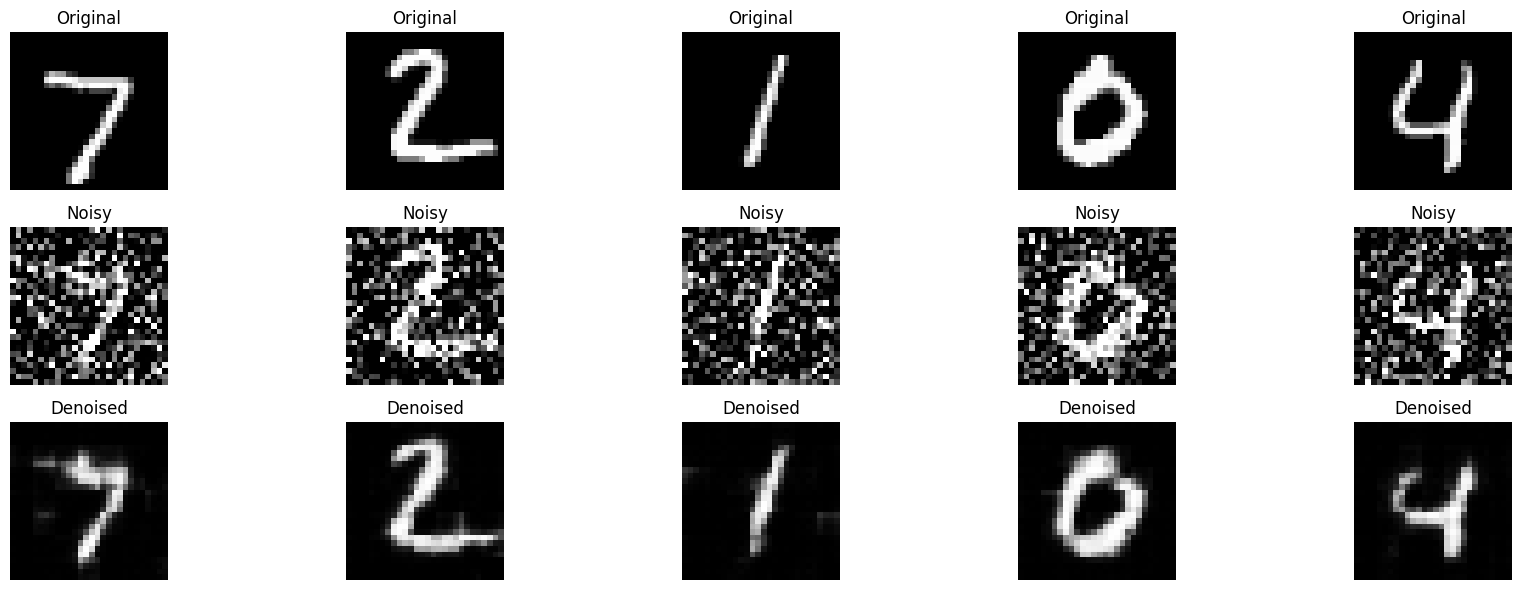

In [13]:
train(model, train_loader, criterion, optimizer, epochs=5)
visualize_denoising(model, test_loader)
